In [19]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import Weibo2014
from moabb.datasets import Zhou2016
from moabb.datasets import BNCI2014004
from moabb.datasets import BNCI2014002
from moabb.datasets import BNCI2015001
from moabb.datasets import AlexMI

from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation


import mne
from mne.preprocessing import Xdawn
from mne.decoding import CSP


from moabb.paradigms import MotorImagery
from moabb.paradigms import P300
from pyriemann.estimation import Covariances
from pyriemann.utils.covariance import covariances
from pyriemann.estimation import ERPCovariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from pyriemann.tangentspace import TangentSpace
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [20]:
paradigm = P300()
paradigm_name = 'P300'

In [21]:
pipelines = {}
pipelines["(1) epo-mdm-euc"] = make_pipeline(MDM(metric="euclid"))
#pipelines["(2) epo-knn-euc"] = make_pipeline(KNearestNeighbor(), MDM(metric="euclid"))
# #default 5 neighbors
#pipelines["(3) cov-dia-lda"] = make_pipeline(Covariances(), _sch), LDA())
# #sch for schaffer
pipelines["(4) epo-csp-lda"] = make_pipeline(CSP(), LDA())
#pipelines["(5) cov-knn-euc"] = make_pipeline(Covariances(), KNearestNeighbor(metric="euclid"))
# # pipelines["(6) cov-knn-rie"] = make_pipeline(Covariances(), KNearestNeighbor())
# # #default riemannian
pipelines["(7) cov-mdm-euc"] = make_pipeline(Covariances(), MDM(metric="euclid"))
# # pipelines["(8) cov-mdm-rie"] = make_pipeline(Covariances(), MDM())
#pipelines["(9) cov-tgs-lda"] = make_pipeline(Covariances(), TangentSpace(), LDA())
# # #(default: 'riemann')



In [22]:
datasets = [AlexMI()]
subj = [1, 2, 3 ,4]
subject_source = 1
d = datasets[0]
d.subject_list = subj
paradigm = paradigm
data_source = {}
X, labels, meta = paradigm.get_data(d, subjects=[subject_source])
data_source['covs'] = Covariances(estimator='lwf').fit_transform(X)
data_source['labels'] = labels

new_labels = []
for elt in labels:
    if elt not in new_labels:
        new_labels.append(elt)

source = {}
target_train = {}
target_test = {}


AssertionError: Dataset Alexandre Motor Imagery is not valid for paradigm

In [9]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(pipelines["(1) epo-mdm-euc"], data_source['covs'], data_source['labels'], cv=cv, scoring='roc_auc')


array([0.46875   , 0.4       , 0.58333333, 0.375     , 0.53333333])

In [10]:
from sklearn.model_selection import KFold

K = 10

cv = KFold(n_splits=K, shuffle=True, random_state=42)
PREDICTION = []
TRUTH = []
for train, test in cv.split(data_source['covs']):
    TRUTH.append(data_source['labels'][test])
    model = MDM(metric="euclid").fit(data_source['covs'][train], data_source['labels'][train])
    a = model.predict(data_source['covs'][test])
    PREDICTION.append(a)

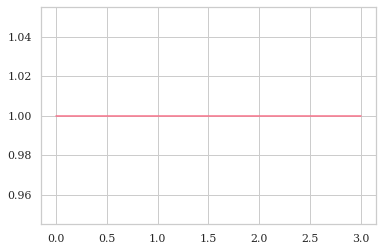

In [13]:


def roc_homemade(prediction, truth):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == new_labels[0] and truth[i] == new_labels[0]:
            tp += 1
        elif prediction[i] == new_labels[1] and truth[i] == new_labels[1]:
            tn += 1
        elif prediction[i] == new_labels[0] and truth[i] == new_labels[1]:
            fp += 1
        elif prediction[i] == new_labels[1] and truth[i] == new_labels[0]:
            fn += 1
    return tp, tn, fp, fn

def sensitivity(tp, tn, fp, fn):
    if tp+fn == 0:
        return 0
    return tp/(tp+fn)

def one_specificity(tp, tn, fp, fn):
    if fp+tn == 0:
        return 0
    return 1- (tn/(tn+fp))

def accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+tn+fp+fn)


l_one_spec = []
l_senstivity = []
for i in range(K):
    tp, tn, fp, fn = roc_homemade(PREDICTION[i], TRUTH[i])
    if one_specificity(tp, tn, fp, fn) != 0 and sensitivity(tp, tn, fp, fn) != 0:
        l_one_spec.append(one_specificity(tp, tn, fp, fn))
        l_senstivity.append(sensitivity(tp, tn, fp, fn))

plt.plot([i for i in range(len(l_senstivity))], l_senstivity)


In [15]:
import csv

with open('sortie.csv', 'w') as csvfile:
    fieldnames = ['','score', 'subject', 'session', 'paradigm']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(l_senstivity)):
        writer.writerow({'': i, 'score': l_senstivity[i], 'subject': subject_source, 'session': 1, 'paradigm': paradigm_name})

In [16]:
def accuracy_homemade(P, T):
    cpt = 0
    m = min(len(P), len(T))
    for k in range(m):
        if P[k] == T[k]:
            cpt+=1
    return cpt/m

for i in range(K):
    print(accuracy_homemade(PREDICTION[i], TRUTH[i]))


0.75
0.5
0.75
0.5
0.75
0.75
0.75
0.0
0.25
0.75


In [17]:
import csv

with open('sortie.csv', 'w') as csvfile:
    fieldnames = ['','score', 'subject', 'session', 'paradigm']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(l_senstivity)):
        writer.writerow({'': i, 'score': l_senstivity[i], 'subject': subject_source, 'session': 1, 'paradigm': paradigm_name})